# Voting methods

This notebook compares a number of common voting methods.

For now, we will assume that all voters exist on a 2D political axis (it's common to treat voters as lying along economic and social axes) ranging from 0 to 5. Voters will prefer candidates that are closest in the space, with the order of preference determined by distance from the voter.

In [13]:
from math import sqrt

def distance(voter, candidate):
    return sqrt((voter['x'] - candidate['x'])**2 + (voter['y'] - candidate['y'])**2)

voter1 = {'x': 0.5, 'y': 1.5}
candidate1 = {'x': 1.0, 'y': 2.0}
candidate2 = {'x': 4.0, 'y': 4.0}

assert distance(voter1, candidate1) < distance(voter1, candidate2)

For these initial examples, we will use an electoral base of 100 voters. Voters will exist in the 8-bloc breakdown of registered voters described by [Pew's Political Typology project](http://www.people-press.org/2017/10/24/political-typology-reveals-deep-fissures-on-the-right-and-left/). Within each category there will be some variation. Later, we may experiment with different distributions of voters.

For candidates, we will use four parties: a center-left party (the Donkeys), a center-right party (the Elephants), a far-left party (the Leaves), and a far-right party (the Hedgehogs). All resemblences to real-life political parties are purely coincidental.

In [42]:
import numpy as np
import pandas as pd
from statistics import mean

def generate_bloc(n, x, y):
    sigma = 0.5
    return [(t[0], t[1]) for t in zip(np.random.normal(x, sigma, n), np.random.normal(y, sigma, n))]

def generate_population():
    blocs = [
        (15, 4.5, 4.5),
        (7, 4.0, 4.0),
        (12, 3.5, 3.5),
        (11, 3.0, 3.0),
        (9, 2.0, 2.0),
        (14, 1.5, 1.5),
        (13, 1.0, 1.0),
        (19, 0.5, 0.5)
    ]
    
    df = pd.DataFrame([voter for bloc in blocs for voter in generate_bloc(*bloc)])
    df.columns = ['x', 'y']
    return df

voters = generate_population()
voters.sample(5)

,x,y
16,4.142209,3.557215
25,3.160411,3.416748
32,3.762340,3.739329
42,3.046455,2.844903
53,2.218673,1.710120


In [45]:
# made-up numbers
candidates = [
    {'party': 'hedgehogs', 'x': 4.5, 'y': 2},
    {'party': 'elephants', 'x': 3.5, 'y': 4},
    {'party': 'donkeys', 'x': 2, 'y': 2},
    {'party': 'leaves', 'x': 0.5, 'y': 2}
]
def order_of_preference(voter):
    return sorted(candidates, key=lambda c: distance(voter, c))[0]['party']

voters['choice'] = voters.apply(order_of_preference, axis=1)
voters.sample(5)

,x,y,choice
34,3.113763,2.826026,elephants
36,4.009740,2.546754,hedgehogs
54,1.420951,1.210425,donkeys
66,1.671864,1.675164,donkeys
2,3.668874,3.729621,elephants


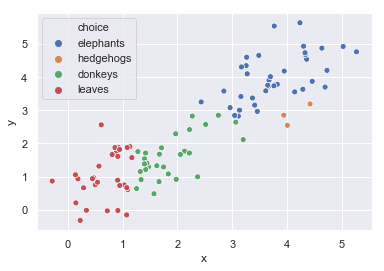

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.scatterplot(x='x', y='y', hue='choice', data=voters)